In [1]:
import torch
from torch import nn
from d2l import torch as d2l

In [2]:
'''
加载WikiText-2数据集，生成用于遮蔽语言模型（MLM）和下一句预测（NSP）的小批量预训练样本。
批量大小为512，输入序列的最大长度为64。原始BERT模型中的最大长度是512。

'''
batch_size, max_len = 512, 64
train_iter, vocab = d2l.load_data_wiki(batch_size, max_len)

In [3]:
'''
这个类定义了BERT模型。它包含了三个主要组件：

BERT编码器：负责将输入的词元序列转换为上下文表示。
MLM（遮蔽语言模型）：负责预测被遮蔽的词元。
NSP（下一句预测）：负责预测两个句子是否为连续句。

模型在前向传播时，
会返回编码后的BERT表示（encoded_X）、遮蔽语言模型的预测（mlm_Y_hat）和下一句预测（nsp_Y_hat）。

'''
class BERTModel(nn.Module):
    '''
    - `vocab_size`：词汇表大小。
    - `num_hiddens`：隐藏层的维度。
    - `norm_shape`：规范化的形状。
    - `ffn_num_input`：前馈神经网络的输入维度。
    - `ffn_num_hiddens`：前馈神经网络的隐藏层维度。
    - `num_heads`：多头注意力机制的头数。
    - `num_layers`：编码器层的数量。
    - `dropout`：丢弃率。
    - `max_len`：输入序列的最大长度。
    - `key_size`、`query_size`、`value_size`：
        注意力机制中的键、查询、值的维度。
    - `hid_in_features`：隐藏层输入特征的维度。
    - `mlm_in_features`：掩蔽语言模型输入特征的维度。
    - `nsp_in_features`：下一句预测输入特征的维度。
    '''
    def __init__(
        self, 
        vocab_size,
        num_hiddens,
        norm_shape,
        ffn_num_input,
        ffn_num_hiddens,
        num_heads,
        num_layers,
        dropout,
        max_len=1000,
        key_size=768,
        query_size=768,
        value_size=768,
        hid_in_features=768,
        mlm_in_features=768,
        nsp_in_features=768
    ):
        super(BERTModel, self).__init__()
        '''
        BERT的编码器部分。`BERTEncoder` 是一个将输入的词元序列转换为上下文表示的模块。
        '''
        self.encoder = d2l.BERTEncoder(
            vocab_size, 
            num_hiddens,
            norm_shape,
            ffn_num_input,
            ffn_num_hiddens,
            num_heads,
            num_layers,
            dropout,
            max_len=max_len,
            key_size=key_size,
            query_size=query_size,
            value_size=value_size
        )
        '''
        隐藏层，用于下一句预测任务。使用了线性变换和 `Tanh` 激活函数。
        '''
        self.hidden = nn.Sequential(
            nn.Linear(
                hid_in_features,
                num_hiddens
            ),
            nn.Tanh()
        )
        '''
        掩蔽语言模型 `MaskLM`，用于预测被遮蔽的词元。
        '''
        self.mlm = d2l.MaskLM(vocab_size, num_hiddens, mlm_in_features)
        '''
        下一句预测 `NextSentencePred`，用于判断两个句子是否是连续的。
        '''
        self.nsp = d2l.NextSentencePred(nsp_in_features)
    def forward(
        self,
        tokens,
        segments,
        valid_lens=None,
        pred_positions=None
    ):
        '''
        将输入的词元 `tokens` 和句子段 `segments` 通过编码器 `self.encoder` 进行处理，
        得到编码后的表示 `encoded_X`。
        '''
        encoded_X = self.encoder(
            tokens,
            segments, 
            valid_lens
        )
        '''
        **掩蔽语言模型的预测**
        如果提供了预测位置 `pred_positions`，则进行掩蔽语言模型的预测，
        得到 `mlm_Y_hat`，否则设置为 `None`。

        '''
        if pred_positions is not None:
            mlm_Y_hat = self.mlm(
                encoded_X, pred_positions
            )
        else:
            mlm_Y_hat = None
        '''
        **下一句预测的预测**
        对编码后的表示 `encoded_X` 进行下一句预测任务。
        `encoded_X[:, 0,:]` 表示取每个输入序列的第一个词元的编码表示，
        通过隐藏层 `self.hidden` 和下一句预测模块 `self.nsp` 得到预测结果 `nsp_Y_hat`。
        '''
        nsp_Y_hat = self.nsp(
            self.hidden(
                encoded_X[:, 0,:]
            )
        )
        '''
        返回编码后的表示 `encoded_X`，掩蔽语言模型的预测 `mlm_Y_hat`，
        以及下一句预测的结果 `nsp_Y_hat`。
        '''
        return encoded_X, mlm_Y_hat, nsp_Y_hat

`BERTModel` 完成了对输入数据的编码、掩蔽语言模型的预测以及下一句预测任务的处理。这些功能使得BERT模型能够进行预训练，并在后续任务中应用。

In [4]:
net = BERTModel(len(vocab), num_hiddens=128, norm_shape=[128],
                    ffn_num_input=128, ffn_num_hiddens=256, num_heads=2,
                    num_layers=2, dropout=0.2, key_size=128, query_size=128,
                    value_size=128, hid_in_features=128, mlm_in_features=128,
                    nsp_in_features=128)
devices = d2l.try_all_gpus()
loss = nn.CrossEntropyLoss()

In [5]:
'''
计算BERT模型在预训练中的两个损失：
遮蔽语言模型损失（MLM损失）和下一句预测损失（NSP损失）。

`_get_batch_loss_bert`，
用于计算一个批次的数据在BERT模型上的损失。函数的参数包括：
- `net`: BERT模型。
- `loss`: 损失函数（通常是交叉熵损失）。
- `vocab_size`: 词汇表大小。
- `tokens_X`: 输入的词元（token）序列。
- `segments_X`: 句子段信息，用于区分句子A和句子B。
- `valid_lens_x`: 输入序列的有效长度。
- `pred_positions_X`: 需要预测的遮蔽词元的位置。
- `mlm_weights_X`: 遮蔽语言模型的权重，用于掩蔽。
- `mlm_Y`: 遮蔽语言模型的标签。
- `nsp_y`: 下一句预测的标签。
'''
def _get_batch_loss_bert(net, loss, vocab_size, tokens_X,
                         segments_X, valid_lens_x,
                         pred_positions_X, mlm_weights_X,
                         mlm_Y, nsp_y):
    '''
    前向传播
    通过BERT模型 `net` 进行前向传播，得到模型的预测结果：
    - `mlm_Y_hat`: 遮蔽语言模型的预测结果。
    - `nsp_Y_hat`: 下一句预测的预测结果。
    '''
    _, mlm_Y_hat, nsp_Y_hat = net(tokens_X, segments_X,
                                  valid_lens_x.reshape(-1),
                                  pred_positions_X)
    '''
    计算遮蔽语言模型损失
    1. `mlm_Y_hat.reshape(-1, vocab_size)` 
        将预测结果 `mlm_Y_hat` 重塑为形状 `[batch_size * max_len, vocab_size]`。
    2. `mlm_Y.reshape(-1)` 
        将标签 `mlm_Y` 重塑为一维数组 `[batch_size * max_len]`。
    3. `loss(mlm_Y_hat.reshape(-1, vocab_size), mlm_Y.reshape(-1))` 
        计算预测结果和标签之间的交叉熵损失。
    4. `* mlm_weights_X.reshape(-1, 1)` 
        乘以遮蔽权重 `mlm_weights_X`。

    '''
    mlm_l = loss(mlm_Y_hat.reshape(-1, vocab_size), mlm_Y.reshape(-1)) *\
    mlm_weights_X.reshape(-1, 1)
    '''
    将所有损失加总并归一化（除以遮蔽权重的总和），得到平均遮蔽语言模型损失 `mlm_l`。
    '''
    mlm_l = mlm_l.sum() / (mlm_weights_X.sum() + 1e-8)
    '''
    计算下一句子预测任务的损失
    1. `nsp_Y_hat`: 下一句预测的预测结果。
    2. `nsp_y`: 下一句预测的标签。
    3. `loss(nsp_Y_hat, nsp_y)` 计算预测结果和标签之间的交叉熵损失。

    '''
    nsp_l = loss(nsp_Y_hat, nsp_y)
    '''
    总损失
    总损失 `l` 是遮蔽语言模型损失 `mlm_l` 和下一句预测任务损失 `nsp_l` 的和。
    '''
    l = mlm_l + nsp_l
    '''
    函数返回三个值：
    - `mlm_l`: 遮蔽语言模型损失。
    - `nsp_l`: 下一句预测任务损失。
    - `l`: 总损失。

    '''
    return mlm_l, nsp_l, l

总结

这个函数的作用是计算一个批次的数据在BERT模型上的遮蔽语言模型损失和下一句预测任务损失，并返回这些损失。它将输入的数据通过模型进行前向传播，计算每个任务的损失，并将这些损失相加得到总损失。通过这个函数，可以评估模型在预训练过程中的表现。

In [6]:
'''
这个函数用于在WikiText-2数据集上预训练BERT模型。函数参数包括：
- `train_iter`: 数据集的迭代器。
- `net`: BERT模型。
- `loss`: 损失函数（通常是交叉熵损失）。
- `vocab_size`: 词汇表的大小。
- `devices`: 训练时使用的设备（例如GPU）。
- `num_steps`: 训练的步数。


'''
def train_bert(train_iter, net, loss, vocab_size, devices, num_steps):
    '''
    这两行代码进行以下操作：
    1. 使用 `nn.DataParallel` 使模型在多个GPU上并行运行，并将模型移动到第一个GPU设备上。
    2. 创建Adam优化器，用于更新模型的参数，学习率设为0.01。
    '''
    net = nn.DataParallel(net, device_ids=devices).to(devices[0])
    trainer = torch.optim.Adam(net.parameters(), lr=0.01)
    '''
    初始化计数器和绘图
    - `step`: 当前的训练步数，初始化为0。
    - `timer`: 计时器，用于记录训练时间。
    - `animator`: 动画绘图对象，用于实时绘制损失。
    - `metric`: 累加器，用于累加遮蔽语言模型损失、下一句预测损失、处理的句子对数和计数。
    - `num_steps_reached`: 布尔值，用于判断是否达到指定的训练步数。
    '''
    step, timer = 0, d2l.Timer()
    animator = d2l.Animator(xlabel='step', ylabel='loss',
                            xlim=[1, num_steps], legend=['mlm', 'nsp'])
    # 遮蔽语言模型损失的和，下一句预测任务损失的和，句子对的数量，计数
    metric = d2l.Accumulator(4)
    num_steps_reached = False
    '''
    外层循环控制训练步数，内层循环遍历数据集的每个批次。每个批次的数据包括：
    - `tokens_X`: 输入的词元序列。
    - `segments_X`: 句子段信息。
    - `valid_lens_x`: 输入序列的有效长度。
    - `pred_positions_X`: 需要预测的遮蔽词元位置。
    - `mlm_weights_X`: 遮蔽语言模型的权重。
    - `mlm_Y`: 遮蔽语言模型的标签。
    - `nsp_y`: 下一句预测的标签。
    '''
    while step < num_steps and not num_steps_reached:
        for tokens_X, segments_X, valid_lens_x, pred_positions_X,\
            mlm_weights_X, mlm_Y, nsp_y in train_iter:
            '''
            将数据移动到第一个GPU设备上，以便在GPU上进行计算。
            '''
            tokens_X = tokens_X.to(devices[0])
            segments_X = segments_X.to(devices[0])
            valid_lens_x = valid_lens_x.to(devices[0])
            pred_positions_X = pred_positions_X.to(devices[0])
            mlm_weights_X = mlm_weights_X.to(devices[0])
            mlm_Y, nsp_y = mlm_Y.to(devices[0]), nsp_y.to(devices[0])
            '''
            - `trainer.zero_grad()`: 清除优化器中保存的梯度。
            - `timer.start()`: 开始计时。
            '''
            trainer.zero_grad()
            timer.start()
            '''
            前向传播和损失计算
            调用 `_get_batch_loss_bert` 函数计算遮蔽语言模型损失 `mlm_l`、
            下一句预测损失 `nsp_l` 和总损失 `l`。
            '''
            mlm_l, nsp_l, l = _get_batch_loss_bert(
                net, loss, vocab_size, tokens_X, segments_X, valid_lens_x,
                pred_positions_X, mlm_weights_X, mlm_Y, nsp_y)
            '''
            反向传播和参数更新
            - `l.backward()`: 计算损失的梯度。
            - `trainer.step()`: 使用优化器更新模型参数。
            '''
            l.backward()
            trainer.step()
            '''
            记录和绘制
            - `metric.add(mlm_l, nsp_l, tokens_X.shape[0], 1)`: 
                累加损失和处理的句子对数量。
            - `timer.stop()`: 
                停止计时。
            - `animator.add(step + 1, (metric[0] / metric[3], metric[1] / metric[3]))`: 
                实时绘制损失曲线。
            '''
            metric.add(mlm_l, nsp_l, tokens_X.shape[0], 1)
            timer.stop()
            animator.add(step + 1,
                         (metric[0] / metric[3], metric[1] / metric[3]))
            '''
            步数增加和停止判断
            - `step += 1`: 增加步数。
            - `if step == num_steps`: 
                如果达到指定的步数，设置 `num_steps_reached` 为 `True` 并跳出循环。

            '''
            step += 1
            if step == num_steps:
                num_steps_reached = True
                break
    '''
    - 打印平均遮蔽语言模型损失和下一句预测损失。
    - 打印每秒处理的句子对数量。
    '''
    print(f'MLM loss {metric[0] / metric[3]:.3f}, '
          f'NSP loss {metric[1] / metric[3]:.3f}')
    print(f'{metric[2] / timer.sum():.1f} sentence pairs/sec on '
          f'{str(devices)}')

总结

这段代码实现了一个完整的BERT预训练过程，包括数据准备、前向传播、损失计算、反向传播、参数更新和结果记录。通过这些步骤，模型能够逐步学习并提高在遮蔽语言模型任务和下一句预测任务上的表现。

MLM loss 5.777, NSP loss 0.772
8226.0 sentence pairs/sec on [device(type='cuda', index=0)]


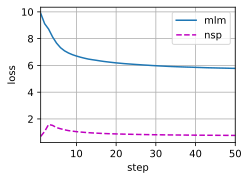

In [7]:
train_bert(train_iter, net, loss, len(vocab), devices, 50)

用BERT表示文本

如何使用预训练的BERT模型来获取文本或文本对中每个词元的BERT表示。

通过函数 `get_bert_encoding` 获取BERT表示，然后展示了单个句子和句子对的BERT编码。

In [8]:
'''
 `get_bert_encoding`，该函数返回输入文本（单个句子或句子对）中每个词元的BERT表示
'''
def get_bert_encoding(net, tokens_a, tokens_b=None):
    '''
    **获取词元和段信息**
    - `tokens_a` 是第一个句子的词元列表。
    - `tokens_b`（可选）是第二个句子的词元列表（如果有的话）。
    - `d2l.get_tokens_and_segments` 函数将两个句子合并，
        并插入特殊标记 `<cls>` 和 `<sep>`。同时，生成段信息，用于区分两个句子的词元。

    '''
    tokens, segments = d2l.get_tokens_and_segments(tokens_a, tokens_b)
    '''
    **词元转ID**
    - `vocab[tokens]` 将词元列表转换为词元ID列表。
    - `torch.tensor(...).unsqueeze(0)` 
        将这些列表转换为张量，并增加一个维度以表示批次大小为1（因为BERT的输入需要有批次维度）。

    '''
    token_ids = torch.tensor(
        vocab[tokens],
        device=devices[0]
    ).unsqueeze(0)
    segments = torch.tensor(
        segments,
        device=devices[0]
    ).unsqueeze(0)
    valid_len = torch.tensor(
        len(tokens),
        device=devices[0]
    ).unsqueeze(0)
    '''
    **通过BERT模型获取表示**
    - 将 `token_ids`、`segments` 和 `valid_len` 作为输入传入BERT模型 `net`，
        获取编码后的表示 `encoded_X`。
    '''
    encoded_X, _, _ = net(token_ids, segments, valid_len)
    '''
    返回BERT模型的编码表示
    '''
    return encoded_X

In [9]:
'''
示例：单个句子
使用这个函数来获取单个句子的BERT表示。

- 句子 `'a crane is flying'` 被拆分成词元列表 `['a', 'crane', 'is', 'flying']`。
- `get_bert_encoding` 函数处理该句子，并返回每个词元的BERT表示。
'''
tokens_a = ['a', 'crane', 'is', 'flying']
encoded_text = get_bert_encoding(
    net, tokens_a
)
'''
 '<cls>' 词元的表示
'''
encoded_text_cls = encoded_text[:, 0, :]
'''
'crane' 词元的表示
'''
encoded_text_crane = encoded_text[:, 2, :]
encoded_text.shape, encoded_text_cls.shape, encoded_text_crane[0][:3]

(torch.Size([1, 6, 128]),
 torch.Size([1, 128]),
 tensor([-0.8987, -0.2387, -0.1346], device='cuda:0', grad_fn=<SliceBackward>))

In [10]:
'''
示例：句子对

我们还可以处理两个句子的组合，获取整个句子对中每个词元的BERT表示。

- 句子对 `'a crane driver came'` 和 `'he just left'` 被拆分成词元列表，
    并组合为 `['<cls>', 'a', 'crane', 'driver', 'came', '<sep>', 'he', 'just', 'left', '<sep>']`。
- `get_bert_encoding` 函数处理这个句子对，并返回每个词元的BERT表示。

'''
tokens_a, tokens_b = ['a', 'crane', 'driver', 'came'], ['he', 'just', 'left']
encoded_pair = get_bert_encoding(net, tokens_a, tokens_b)
'''
'<cls>' 词元的表示
'''
encoded_pair_cls = encoded_pair[:, 0, :]
'''
'crane' 词元的表示
'''
encoded_pair_crane = encoded_pair[:, 2, :]
'''
展示每个句子或句子对的BERT表示的形状和特定词元的前三个元素。
- `encoded_text.shape` 和 `encoded_pair.shape` 表示返回的编码张量的形状，
    分别为 `[1, 6, 128]` 和 `[1, 10, 128]`。
  - 其中 `1` 是批次大小，`6` 和 `10` 是输入序列的长度，`128` 是BERT表示的隐藏层维度。
- `encoded_text_cls.shape` 和 `encoded_pair_cls.shape` 表示 `<cls>` 词元的BERT表示的形状，
    都是 `[1, 128]`。
- `encoded_text_crane[0][:3]` 和 `encoded_pair_crane[0][:3]` 表示 `crane` 词元的BERT表示的前三个元素，
    展示了上下文不同情况下的差异。
'''
encoded_pair.shape, encoded_pair_cls.shape, encoded_pair_crane[0][:3]

(torch.Size([1, 10, 128]),
 torch.Size([1, 128]),
 tensor([-0.8884, -0.0268, -0.0587], device='cuda:0', grad_fn=<SliceBackward>))

总结

通过这段代码，我们展示了如何使用预训练的BERT模型来获取文本或文本对中每个词元的上下文敏感表示。这些表示可以用于各种下游任务，如分类、问答等。